In [838]:
import pandas as pd
import numpy as np
import plotly_express as px
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, PULP_CBC_CMD
from datetime import datetime
import csv
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [799]:
source_dir = os.path.join("data", "raw")

In [800]:
df_16_22 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_16-22.csv"))
df_23_24 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_23-24.csv"))

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_20664/2646544372.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_16_22 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_16-22.csv"))


In [801]:
df_players = pd.read_csv(os.path.join(source_dir, "player_idlist.csv"))
df_teams = pd.read_csv(os.path.join(source_dir, "teams.csv"))

In [802]:
df_new_player_stats = pd.read_csv(os.path.join(source_dir, "cleaned_players_24-25_11082024.csv"))
df_new_player_stats["name"] = df_new_player_stats['first_name'] + " " + df_new_player_stats["second_name"]
df_new_player_stats.drop(['first_name', 'second_name'], axis=1, inplace=True)

# *Inspect Data*

In [803]:
df_16_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [804]:
df_16_22.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [805]:
df_23_24.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1


In [806]:
df_teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,...,NaN,False,0,1350,1380,1370,1370,1330,1390,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,...,NaN,False,0,1120,1245,1110,1140,1130,1350,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,...,NaN,False,0,1100,1100,1075,1100,1130,1105,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,...,NaN,False,0,1100,1100,1105,1095,1100,1110,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,...,NaN,False,0,1100,1100,1100,1105,1100,1100,131


In [807]:
df_players.head()

,first_name,second_name,id
0,Fábio,Ferreira Vieira,1
1,Gabriel,Fernando de Jesus,2
2,Gabriel,dos Santos Magalhães,3
3,Kai,Havertz,4
4,Karl,Hein,5


# *Clean Data*

### Join Data

In [808]:
# create consistent columns between DFs
#df_16_22["first_name"] = df_16_22["name"].apply(lambda name: name.split(' ')[0])
#df_16_22["second_name"] = df_16_22["name"].apply(lambda name: name.split(' ')[1])

In [809]:
df_23_24["season_x"] = "2023-24"
df_23_24.rename(columns={"team_x": "team"}, inplace=True)
df_16_22.rename(columns={"team_x": "team"}, inplace=True)

In [810]:
# combine dfs
df = pd.concat([df_16_22, df_23_24], ignore_index=True)

df.rename(columns={
    "team_x": "team",
    "season_x": "season",
}, inplace=True)

df

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,value,was_home,yellow_cards,GW,xP,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,55,False,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,60,True,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,80,True,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,50,False,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,45,True,1,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125889,2023-24,Kyle Walker,DEF,Man City,0,0,15,0,11.6,369,...,55,True,0,38,7.5,0.06,0.06,0.0,0.36,1.0
125890,2023-24,Jacob Brown,FWD,Luton,0,0,0,0,0.0,631,...,49,True,0,38,0.0,0.00,0.00,0.0,0.00,0.0
125891,2023-24,Vicente Guaita,GK,Crystal Palace,0,0,0,0,0.0,227,...,44,True,0,38,0.0,0.00,0.00,0.0,0.00,0.0
125892,2023-24,Braian Ojeda Rodríguez,MID,Nott'm Forest,0,0,0,0,0.0,459,...,45,False,0,38,0.0,0.00,0.00,0.0,0.00,0.0


### Drop non-mutual columns that can't be used

In [812]:
df['played'] = df['minutes'] > 5

df = df.drop([
    "xP",
    "expected_assists",
    "expected_goal_involvements",
    "expected_goals",
    "expected_goals_conceded",
    "starts",
    "opp_team_name",
    #"team",

], axis=1)

### Add player IDs

In [813]:
# add player_ids to the main dataset based on first and second name

df_players["name"] = df_players["first_name"] + " " + df_players["second_name"]

df = pd.merge(df, df_players.drop(["first_name", "second_name"], axis=1), how="left", on=["name"])

df.rename(columns={'id': 'player_id'}, inplace=True)

df.head()

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,played,player_id
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,0,0,0,0,55,False,0,1,False,517.0
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1,0,0,0,60,True,0,1,True,NaN
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,2,0,0,0,80,True,0,1,True,NaN
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,0,0,0,0,50,False,0,1,False,217.0
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1,0,0,0,45,True,1,1,True,NaN


In [814]:
# players who have no ID means they're not available for picking the current season (player IDs come from this season's players) - thus we drop them
df = df.dropna(subset='player_id', axis=0)

### Map players to teams

In [815]:
df.columns

Index(['season', 'name', 'position', 'team', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'played', 'player_id'],
      dtype='object')

In [816]:
# create a dictionary mapping player_id to team
player_team_mapping = df[df['team'].notna()][['player_id', 'team']].set_index('player_id')['team'].to_dict()

# fill in NaN values in 'team_x' based on player_id mapping
for index, row in df.iterrows():
    if pd.isnull(row['team']):
        player_id = row['player_id']
        if player_id in player_team_mapping:
            df.at[index, 'team'] = player_team_mapping[player_id]

In [817]:
# create a dictionary to map teams to codes
team_codes = {}
teams = df['team'].dropna().unique()
teams.sort()  # Sort teams alphabetically

# Assign codes to teams
for i, team in enumerate(teams):
    team_codes[team] = i + 1  # Start codes from 1

# Create a new column 'team_code' in the DataFrame
df['team_code'] = df['team'].map(team_codes)

# Display team names and their codes
for team, code in team_codes.items():
    print(f"Team: {team}, Code: {code}")

Team: Arsenal, Code: 1
Team: Aston Villa, Code: 2
Team: Bournemouth, Code: 3
Team: Brentford, Code: 4
Team: Brighton, Code: 5
Team: Burnley, Code: 6
Team: Chelsea, Code: 7
Team: Crystal Palace, Code: 8
Team: Everton, Code: 9
Team: Fulham, Code: 10
Team: Leeds, Code: 11
Team: Leicester, Code: 12
Team: Liverpool, Code: 13
Team: Luton, Code: 14
Team: Man City, Code: 15
Team: Man Utd, Code: 16
Team: Newcastle, Code: 17
Team: Norwich, Code: 18
Team: Nott'm Forest, Code: 19
Team: Sheffield Utd, Code: 20
Team: Southampton, Code: 21
Team: Spurs, Code: 22
Team: Watford, Code: 23
Team: West Brom, Code: 24
Team: West Ham, Code: 25
Team: Wolves, Code: 26


### Add current player costs

In [818]:
new_player_costs = df_new_player_stats[['name', 'now_cost']]

new_player_costs

,name,now_cost
0,Fábio Ferreira Vieira,55
1,Gabriel Fernando de Jesus,70
2,Gabriel dos Santos Magalhães,60
3,Kai Havertz,80
4,Karl Hein,40
...,...,...
579,Rodrigo Martins Gomes,55
580,Santiago Bueno,45
581,Pablo Sarabia,55
582,Jørgen Strand Larsen,55


In [819]:
# Create a new column 'new_value' and initialize it with the 'value' column
df['new_value'] = df['value']

# Merge df with new_player_costs to align names and now_cost
df = df.merge(new_player_costs, on='name', how='inner')

# Update the 'new_value' column with 'now_cost' where it's available, otherwise keep the original 'new_value'
df['new_value'] = df['now_cost'].combine_first(df['new_value'])

# Drop the 'now_cost' column as it's no longer needed
df = df.drop(columns=['now_cost'])

# Display the updated DataFrame
df

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,transfers_in,transfers_out,value,was_home,yellow_cards,GW,played,player_id,team_code,new_value
0,2016-17,Aaron Cresswell,DEF,West Ham,0,0,0,0,0.0,454,...,0,0,55,False,0,1,False,517.0,25,40
1,2016-17,Abdoulaye Doucouré,MID,Everton,0,0,0,0,0.0,482,...,0,0,50,False,0,1,False,217.0,9,55
2,2016-17,Adam Lallana,MID,Brighton,1,2,33,0,33.7,205,...,0,0,70,False,1,1,True,463.0,5,50
3,2016-17,Adam Smith,DEF,Bournemouth,0,0,23,0,4.3,34,...,0,0,45,True,0,1,True,81.0,3,45
4,2016-17,Alex Iwobi,MID,Fulham,1,0,12,0,17.5,21,...,0,0,60,True,1,1,True,247.0,10,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51601,2023-24,Tyrell Malacia,DEF,Man Utd,0,0,0,0,0.0,389,...,44,21,43,False,0,38,False,379.0,16,45
51602,2023-24,Hákon Valdimarsson,GK,Brentford,0,0,0,0,0.0,789,...,50,35,40,True,0,38,False,109.0,4,40
51603,2023-24,Đorđe Petrović,GK,Chelsea,0,0,18,0,0.0,687,...,46910,24765,47,True,0,38,True,183.0,7,45
51604,2023-24,Chris Richards,DEF,Crystal Palace,0,0,29,1,11.4,238,...,25020,5091,39,True,0,38,True,194.0,8,45


In [820]:
# Check if all names in df['name'] are present in df_new_player_stats['name']
missing_names = set(df['name'].unique()) - set(df_new_player_stats['name'].unique())

# If there are no missing names, the assertion passes
assert len(missing_names) == 0, f"Missing names after merge: {missing_names}"

In [821]:
# TODO - any team changes not represented in the most recent data?

# Define a dictionary to map player names to their new teams
player_team_changes = {
    'Mason Mount': 'Man Utd',
    'James Maddison': 'Spurs',
    'Declan Rice': 'Arsenal',
    'Kai Havertz': 'Arsenal',
    'Youri Tielemans': 'Aston Villa',
    'João Pedro Junqueira de Jesus': 'Brighton',
    'Robert Sánchez': 'Chelsea',
    'Ashley Young': 'Everton',
    'Alexis Mac Allister': 'Liverpool',
    'Harvey Barnes': 'Newcastle'
}

# Update the 'team_x' column for the players
#for player_name, new_team in player_team_changes.items():
    #df.loc[df['name'] == player_name, 'team_x'] = new_team

### Encoding

In [822]:
# Convert 'was_home' from boolean to int64
df['was_home'] = df['was_home'].astype(int)

df['player_id'] = df['player_id'].astype(int)

In [823]:
# Convert positions to numbers
position_mapping = {'GK': 0, 'GKP': 0, 'DEF': 1, 'MID': 2, 'FWD': 3}
df['position'] = df['position'].map(position_mapping)
df['position'] = df['position'].astype(int)

# *Feature Engineering*

### Dates

In [824]:
df["kickoff_time"]

0        2016-08-15T19:00:00Z
1        2016-08-13T14:00:00Z
2        2016-08-14T15:00:00Z
3        2016-08-14T12:30:00Z
4        2016-08-14T15:00:00Z
                 ...         
51601    2024-05-19T15:00:00Z
51602    2024-05-19T15:00:00Z
51603    2024-05-19T15:00:00Z
51604    2024-05-19T15:00:00Z
51605    2024-05-19T15:00:00Z
Name: kickoff_time, Length: 51606, dtype: object

In [825]:
# Convert Kickoff Time to datetime and Extract Features
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
df['year'] = df['kickoff_time'].dt.year
df['month'] = df['kickoff_time'].dt.month
df['day_of_month'] = df['kickoff_time'].dt.day
df['day_of_week'] = df['kickoff_time'].dt.dayofweek
df['time'] = df['kickoff_time'].dt.hour * 100 + df['kickoff_time'].dt.minute

# *ML Model Creation*

### Initial model

In [826]:
df.head()

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,GW,played,player_id,team_code,new_value,year,month,day_of_month,day_of_week,time
0,2016-17,Aaron Cresswell,1,West Ham,0,0,0,0,0.0,454,...,1,False,517,25,40,2016,8,15,0,1900
1,2016-17,Abdoulaye Doucouré,2,Everton,0,0,0,0,0.0,482,...,1,False,217,9,55,2016,8,13,5,1400
2,2016-17,Adam Lallana,2,Brighton,1,2,33,0,33.7,205,...,1,True,463,5,50,2016,8,14,6,1500
3,2016-17,Adam Smith,1,Bournemouth,0,0,23,0,4.3,34,...,1,True,81,3,45,2016,8,14,6,1230
4,2016-17,Alex Iwobi,2,Fulham,1,0,12,0,17.5,21,...,1,True,247,10,55,2016,8,14,6,1500


In [827]:
string_cols = df.select_dtypes(["object"])

string_cols

,season,name,team
0,2016-17,Aaron Cresswell,West Ham
1,2016-17,Abdoulaye Doucouré,Everton
2,2016-17,Adam Lallana,Brighton
3,2016-17,Adam Smith,Bournemouth
4,2016-17,Alex Iwobi,Fulham
...,...,...,...
51601,2023-24,Tyrell Malacia,Man Utd
51602,2023-24,Hákon Valdimarsson,Brentford
51603,2023-24,Đorđe Petrović,Chelsea
51604,2023-24,Chris Richards,Crystal Palace


In [828]:
"""# drop NaN values
df = df.dropna()

# TODO - better to train like you do time-series?

# prepare Data
X = df.drop(['name', 'kickoff_time', 'team','total_points', 'season'], axis=1)
y = df['total_points']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# train the model
rf_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf_model.predict(X_test)

# evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)"""

'# drop NaN values\ndf = df.dropna()\n\n# TODO - better to train like you do time-series?\n\n# prepare Data\nX = df.drop([\'name\', \'kickoff_time\', \'team\',\'total_points\', \'season\'], axis=1)\ny = df[\'total_points\']\n\n# split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\n# random Forest Regression model\nrf_model = RandomForestRegressor(random_state=42)\n\n# train the model\nrf_model.fit(X_train, y_train)\n\n# make predictions on the test set\ny_pred = rf_model.predict(X_test)\n\n# evaluate the model using MSE\nmse = mean_squared_error(y_test, y_pred)\nprint("Mean Squared Error (MSE):", mse)'

In [829]:
# prepare Data
X = df.drop(['name', 'kickoff_time', 'team','total_points', 'season'], axis=1)
y = df['total_points']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# random Forest Regression model
xgb_model = XGBRegressor(random_state=42)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_model.predict(X_test)

# evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.031054146317330625


### Calculating weighted predicted points

https://www.fantasyfootballhub.co.uk/fixture-ticker

In [830]:
# Predict total_points for all players
df['predicted_total_points'] = xgb_model.predict(X)

# Convert position to string
df['position'] = df['position'].astype(str)

# Convert kickoff_time to timezone-naive datetime
df['kickoff_time'] = pd.to_datetime(df['kickoff_time']).dt.tz_localize(None)

# Calculate days ago for each match
df['days_ago'] = (pd.Timestamp('now') - df['kickoff_time']).dt.days

# Define the decay rate for exponential weighting
decay_rate = 0.001

# Calculate weights based on match dates
df['weight'] = np.exp(-decay_rate * df['days_ago'])

# Fixture difficulty ratings dictionary
fixture_difficulty = {
    'Arsenal': [1.77, 1.01, 1.73, 1.02, 0.67, 1.76],
    'Aston Villa': [1.18, 1.00, 1.26, 1.74, 1.77, 1.39],
    'Bournemouth': [1.14, 1.39, 1.24, 1.44, 0.78, 1.84],
    'Brentford': [1.54, 0.78, 1.84, 0.67, 1.02, 1.69],
    'Brighton': [1.24, 1.55, 0.60, 1.89, 1.64, 0.95],
    'Chelsea': [1.09, 1.27, 1.54, 1.12, 1.18, 1.73],
    'Crystal Palace': [1.14, 1.69, 0.95, 1.76, 1.55, 1.24],
    'Everton': [1.73, 1.02, 1.62, 1.01, 1.26, 1.54],
    'Fulham': [1.06, 1.76, 1.39, 1.69, 1.39, 1.14],
    'Liverpool': [1.39, 1.64, 1.06, 1.64, 1.62, 1.27],
    'Man City': [0.95, 1.89, 1.18, 1.64, 1.00, 0.90],
    'Man Utd': [1.60, 1.23, 1.24, 1.34, 1.04, 1.52],
    'Newcastle': [1.84, 1.12, 1.52, 1.27, 1.10, 1.09],
    'Nott’m Forest': [1.62, 1.34, 1.77, 0.78, 1.23, 1.60],
    'Spurs': [1.26, 1.74, 0.90, 1.00, 1.64, 1.06],
    'West Ham': [1.51, 1.04, 1.09, 1.10, 1.44, 1.14],
    'Wolves': [0.60, 1.44, 1.14, 1.39, 1.01, 1.24],
    'Ipswich': [1.24, 0.67, 1.60, 1.23, 1.34, 1.51],  # Replacing Burnley
    'Leicester': [1.52, 1.10, 1.51, 1.04, 1.74, 0.60]   # Replacing Sheffield Utd
}

# Define the weights for each fixture
weights = [24, 22, 20, 18, 16, 14]

# Calculate fixture weights for each team
calculated_fixture_weights = {}

for team, difficulties in fixture_difficulty.items():
    # calculate the weighted sum of difficulties
    weighted_sum = sum(d * w for d, w in zip(difficulties, weights))
    
    # calculate the total weight
    total_weight = sum(weights)
    
    # calculate the weighted average
    weighted_average = weighted_sum / total_weight
    
    # store the result in the calculated_fixture_weights dictionary
    calculated_fixture_weights[team] = round(weighted_average, 4)  # rounding to 4 decimal places for clarity

# Replace the hard-coded fixture_weights with calculated ones
fixture_weights = calculated_fixture_weights

# Create a new column 'weighted_predicted_points' in the dataframe using the calculated weights
df['weighted_predicted_points'] = df.apply(
    lambda row: row['predicted_total_points'] * row['weight'] * fixture_weights.get(row['team'], 0),
    axis=1
)

# Create a list of players to be excluded from the team
# TODO - players out of the PL?
players_to_exclude = ['Tim Krul', 'Michail Antonio', 'Matheus Pereira', 'Gabriel Fernando de Jesus', 'Roberto Firmino', 'Sergio Romero', 'Marcos Alonso', 'Cédric Soares',
                    'Lucas Rodrigues Moura da Silva', 'Fraser Forster', 'Anthony Martial', 'Chris Wood', 'Gareth Bale', 'Bruno Guimarães Rodriguez Moura', 'Son Heung-min',
                    'Jack Harrison', 'Ayoze Pérez', 'Kurt Zouma', 'João Cancelo','Pablo Fornals', 'Christian Pulisic', 'Reiss Nelson', 'Kevin De Bruyne', 'Richarlison de Andrade',
                    'Kasper Schmeichel', 'Eldin Jakupovic', 'Tom Heaton', 'Matt Doherty', 'Kyle Walker-Peters', 'Sergio Agüero', 'Romelu Lukaku', 'Riyad Mahrez', 'Leandro Trossard',
                    'Dean Henderson', 'Marcus Tavernier', 'Ivan Toney', 'Kelechi Iheanacho', 'Kieffer Moore', 'Adam Lallana', 'João Pedro Cavaco Cancelo', 'Benjamin Mendy',
                    'Edinson Cavani', 'Sadio Mané', 'Cristiano Ronaldo dos Santos Aveiro', 'Timo Werner', 'Pierre-Emerick Aubameyang', 'Tammy Abraham', 'Kieran Tierney',
                    'Dominic Calvert-Lewin', 'Raphaël Varane', 'Christian Eriksen', 'Darwin Núñez Ribeiro', 'Edward Nketiah', 'Danny Ings', 'Pontus Jansson', 'Oleksandr Zinchenko']

players_to_exclude = ['Fabian Schär']

# Filter out excluded players
df = df[~df['name'].isin(players_to_exclude)]

In [831]:
# Filter the DataFrame to only include rows from the year 2024
filtered_df_2024 = df[df['year'] == 2024]

# Mark whether the player has played in each match
filtered_df_2024['played_match'] = filtered_df_2024['minutes'] > 0

# Calculate total matches and matches played for each player in 2024
player_match_counts = filtered_df_2024.groupby('name')['played_match'].agg(['count', 'sum']).reset_index()
player_match_counts.columns = ['name', 'total_matches', 'matches_played']

# Calculate the percentage of matches played
player_match_counts['percentage_played'] = player_match_counts['matches_played'] / player_match_counts['total_matches']

# Filter out players who played less than 70% of their matches in 2024
active_players = player_match_counts[player_match_counts['percentage_played'] >= 0.7]['name']

# Filter the original DataFrame to include only active players
df = df[df['name'].isin(active_players)]

# filtered_df now contains players who played at least 70% of matches in 2024


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_20664/590974296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_2024['played_match'] = filtered_df_2024['minutes'] > 0


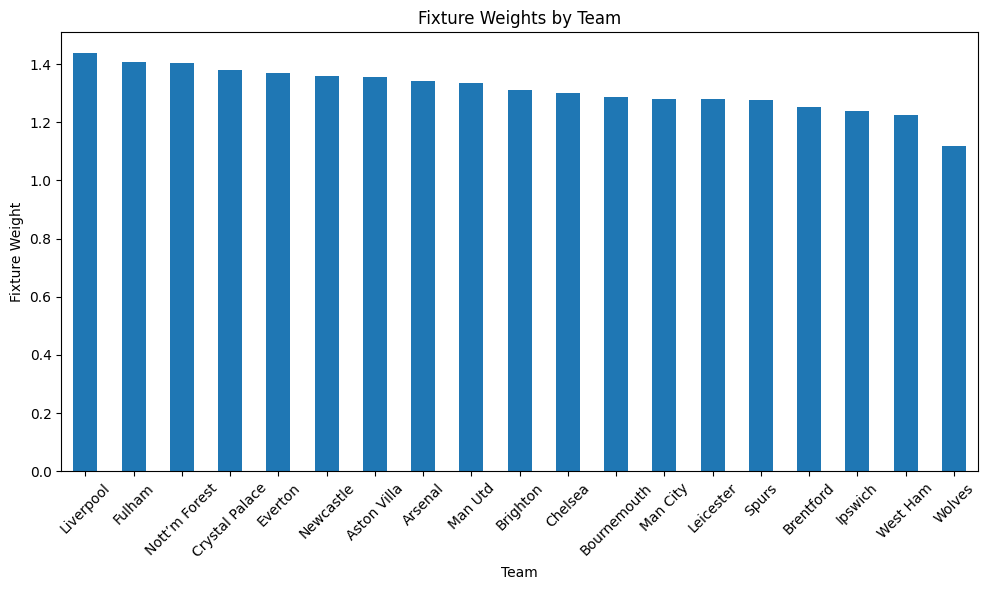

In [832]:
fixture_weights_df = pd.DataFrame.from_dict(fixture_weights, orient='index', columns=['Fixture_Weight'])
fixture_weights_df = fixture_weights_df.sort_values(by='Fixture_Weight', ascending=False)

plt.figure(figsize=(10, 6))
fixture_weights_df['Fixture_Weight'].plot(kind='bar')
plt.title('Fixture Weights by Team')
plt.xlabel('Team')
plt.ylabel('Fixture Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [833]:
df[df['name']=='Cole Palmer'].tail(20)

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,new_value,year,month,day_of_month,day_of_week,time,predicted_total_points,days_ago,weight,weighted_predicted_points
42951,2023-24,Cole Palmer,2,Chelsea,0,0,0,0,0.0,362,...,105,2023,12,27,2,1930,-0.000738,231,0.793739,-0.000761
43383,2023-24,Cole Palmer,2,Chelsea,1,3,57,0,27.6,362,...,105,2023,12,30,5,1230,17.923550,228,0.796124,18.544477
43817,2023-24,Cole Palmer,2,Chelsea,0,3,28,1,26.3,362,...,105,2024,1,13,5,1230,9.880999,214,0.807348,10.367440
44257,2023-24,Cole Palmer,2,Chelsea,0,0,7,0,5.6,362,...,105,2024,1,31,2,2015,1.925687,196,0.822012,2.057187
44703,2023-24,Cole Palmer,2,Chelsea,0,1,25,0,18.3,362,...,105,2024,2,4,6,1400,7.818712,192,0.825307,8.386107
45149,2023-24,Cole Palmer,2,Chelsea,2,2,30,0,38.3,362,...,105,2024,2,12,0,2000,9.713717,184,0.831936,10.502313
45660,2023-24,Cole Palmer,2,Chelsea,0,0,3,1,5.1,362,...,105,2024,2,17,5,1730,2.022664,179,0.836106,2.197833
46477,2023-24,Cole Palmer,2,Chelsea,1,0,23,0,35.7,362,...,105,2024,3,2,5,1500,4.987907,165,0.847894,5.496288
46947,2023-24,Cole Palmer,2,Chelsea,1,3,34,0,33.2,362,...,105,2024,3,11,0,2000,13.193837,156,0.855559,14.670026
47556,2023-24,Cole Palmer,2,Chelsea,0,3,53,0,64.3,362,...,105,2024,3,30,5,1500,15.010730,137,0.871970,17.010347


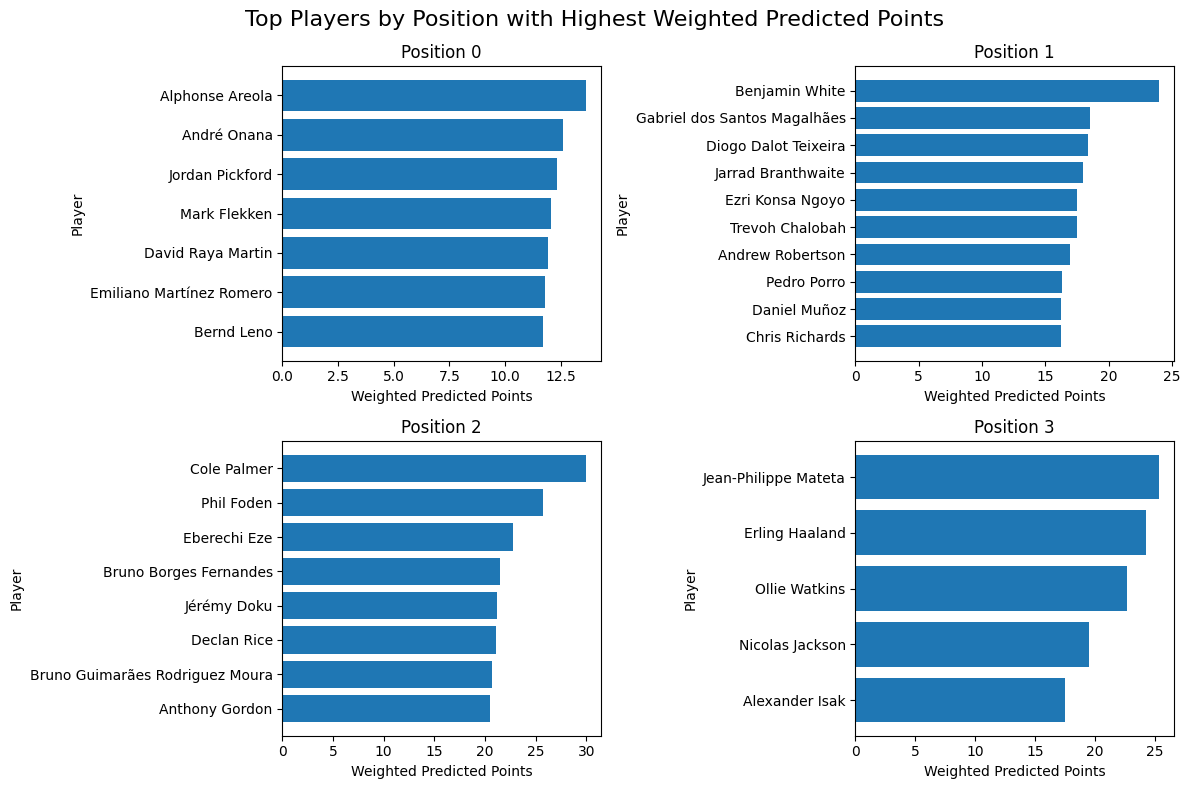

In [834]:
# Create a dictionary to map positions to their index
position_indices = {'0': 0, '1': 1, '2': 2, '3': 3}

# Initialize a figure with subplots for each position
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Top Players by Position with Highest Weighted Predicted Points', fontsize=16)

# Loop through each position and create a subplot
for position, ax in zip(position_indices.keys(), axes.flat):
    # Filter players by position
    position_players = df[df['position'] == position]
    
    # Sort players by 'weighted_predicted_points' in descending order
    position_players_sorted = position_players.sort_values(by='weighted_predicted_points', ascending=False)
    
    # Select the top 10 players
    top_position_players = position_players_sorted.head(10)
    
    # Create a bar plot for the position
    ax.barh(top_position_players['name'], top_position_players['weighted_predicted_points'])
    ax.set_title(f'Position {position}')
    ax.set_xlabel('Weighted Predicted Points')
    ax.set_ylabel('Player')
    ax.invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Optimization Model

The aim is to maximize the total weighted predicted points of the selected players.

In [839]:
# Initialize the optimization problem
model = LpProblem(name="FPL_Team_Selection", sense=LpMaximize)

# Filter out players from teams not in the fixture difficulty dictionary (since they aren't playing this season)
players = [i for i in df.index if df['team'][i] in fixture_difficulty]

# Variables: Binary variable indicating whether a player is selected or not
player_vars = LpVariable.dicts("Player", players, cat="Binary")

def add_player_constraints(model, players):
    # Objective: Maximize total weighted predicted points
    model += lpSum(df['weighted_predicted_points'][i] * player_vars[i] for i in players)
    
    # Total budget constraints
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) <= 830
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) >= 820
    
    # Position constraints
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '0') == 1  # 1 goalkeeper
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') >= 3  # min 3 defenders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') <= 5 # max 5 defenders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') >= 2  # min 2 midfielders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') <= 5 # max 5 midfielders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') >= 1  # min 1 forward
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') <= 3 # max 3 forwards
    
    # Exactly 11 players must be selected
    model += lpSum(player_vars[i] for i in players) == 11
    
    # Exclude specific players from the team
    if 'players_to_exclude' in globals():
        for player in players:
            if df['name'][player] in players_to_exclude:
                model += player_vars[player] == 0
    
    # No more than 3 players from a single team
    teams = df['team'].unique()
    for team in teams:
        team_players = [i for i in players if df['team'][i] == team]
        model += lpSum(player_vars[i] for i in team_players) <= 3

    # Ensure that only one fixture is selected per player
    unique_players = df['name'].unique()
    for player_name in unique_players:
        player_entries = [i for i in players if df['name'][i] == player_name]
        model += lpSum(player_vars[i] for i in player_entries) <= 1

# Add all player constraints
add_player_constraints(model, players)

# Solve the optimization problem
solver = PULP_CBC_CMD(timeLimit=600)  # Adding a time limit of 10 minutes for solving
model.solve(solver)

# Get the recommended players
recommended_players = [i for i in players if player_vars[i].varValue == 1]

# Generate the filename with today's date
filename = f"predicted_team_{datetime.today().strftime('%Y-%m-%d')}.csv"

# Open the file for writing
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(["Player", "Position", "Predicted Points", "Value"])
    
    # Write the player details
    for player in recommended_players:
        writer.writerow([
            df['name'][player], 
            df['position'][player], 
            df['weighted_predicted_points'][player], 
            df['new_value'][player]
        ])


# Print the recommended players and their positions
for player in recommended_players:
    print(f"Player: {df['name'][player]}, Position: {df['position'][player]}, Predicted Points: {df['weighted_predicted_points'][player]}, Value: {df['new_value'][player]}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ossianhempel/repos/fpl/.venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/22754484f5fd43d39a0fe475418121a2-pulp.mps -max -sec 600 -timeMode elapsed -branch -printingOptions all -solution /var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/22754484f5fd43d39a0fe475418121a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 224 COLUMNS
At line 193418 RHS
At line 193638 BOUNDS
At line 213093 ENDATA
Problem MODEL has 219 rows, 19454 columns and 134831 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 244.937 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tighten

# *Sources*

@misc{anand2016fantasypremierleague, title = {{FPL Historical Dataset}}, author = {Anand, Vaastav}, year = {2022}, howpublished = {Retrieved August 2023 from \url{https://github.com/vaastav/Fantasy-Premier-League/}} }

https://github.com/neelthakurdas/fpl_points_predictor/tree/main